In [ ]:
# Cell 1: Imports and config
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib
import json

RANDOM_STATE = 42
DATA_PATH = "rock_density_xray.csv"
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

### Loading the saved model and making predictions

In [ ]:
import joblib
import pandas as pd
import os

# Define the path to the saved model
model_path = os.path.join("models", "rf_rebound_density.joblib")

# Load the model
loaded_model = joblib.load(model_path)
print(f"Model loaded from: {model_path}")

# Create a sample DataFrame for prediction, similar to X_test
sample_data = pd.DataFrame({"rebound_signal": [20.0, 45.0, 70.0, 95.0]})

# Make predictions using the loaded model
loaded_preds = loaded_model.predict(sample_data)

print("\nSample Data for Prediction:\n", sample_data)
print("\nPredictions from Loaded Model:\n", loaded_preds)

In [ ]:
# Cell 2: Load dataset
df = pd.read_csv(DATA_PATH, header=0)
df.columns = [c.strip().replace(" ", "_").replace("/", "_") for c in df.columns]
df.head()

,Rebound_Signal_Strength_nHz,Rock_Density_kg_m3
0,72.945124,2.456548
1,14.229877,2.601719
2,36.597334,1.967004
3,9.578899,2.300439
4,21.765897,2.452374


Shape: (300, 2)
                             count       mean        std       min        25%  \
Rebound_Signal_Strength_nHz  300.0  49.725766  28.341792  0.700227  25.685798   
Rock_Density_kg_m3           300.0   2.225063   0.314512  1.500000   1.987830   

                                   50%        75%        max  
Rebound_Signal_Strength_nHz  50.602886  74.854294  98.831658  
Rock_Density_kg_m3            2.268597   2.476944   2.750000  


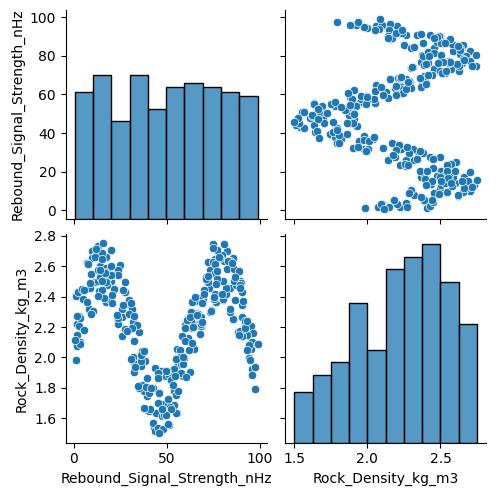

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Rebound_Signal_Strength_nHz  300 non-null    float64
 1   Rock_Density_kg_m3           300 non-null    float64
dtypes: float64(2)
memory usage: 4.8 KB
None
Missing values per column:
 Rebound_Signal_Strength_nHz    0
Rock_Density_kg_m3             0
dtype: int64


In [ ]:
# Cell 3: Quick EDA
print("Shape:", df.shape)
print(df.describe().T)
sns.pairplot(df)
plt.show()

# Check missing values and dtypes
print(df.info())
print("Missing values per column:\n", df.isna().sum())

In [ ]:
# Cell 4: Rename columns for convenience
# Assuming columns are: Rebound_Signal_Strength_nHz, Rock_Density_kg_m3
# If names differ, adjust accordingly
df.columns = ["rebound_signal", "rock_density"]
df = df.dropna().reset_index(drop=True)

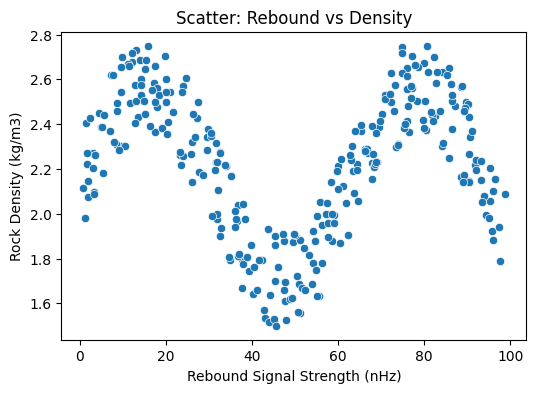

In [ ]:
# Cell 5: Feature / target split and visualization
X = df[["rebound_signal"]]
y = df["rock_density"]

plt.figure(figsize=(6,4))
sns.scatterplot(x=X["rebound_signal"], y=y)
plt.xlabel("Rebound Signal Strength (nHz)")
plt.ylabel("Rock Density (kg/m3)")
plt.title("Scatter: Rebound vs Density")
plt.show()

In [ ]:
# Cell 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (240, 1) Test size: (60, 1)


In [ ]:
# Cell 7: Baseline model and pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(random_state=RANDOM_STATE))
])

# Quick baseline with default params and cross-val
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
print("CV RMSE (baseline):", -cv_scores.mean())

CV RMSE (baseline): 0.15964421977617252


In [ ]:
# Cell 8: Hyperparameter tuning with GridSearchCV
param_grid = {
    "rf__n_estimators": [100, 200],
    "rf__max_depth": [None, 6, 12],
    "rf__min_samples_split": [2, 5],
    "rf__min_samples_leaf": [1, 2]
}

gs = GridSearchCV(pipeline, param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
print("Best CV RMSE:", -gs.best_score_)
best_model = gs.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'rf__max_depth': 6, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
Best CV RMSE: 0.14552110041176958


Test RMSE: 0.1429
Test MAE: 0.1246
Test R2: 0.8050


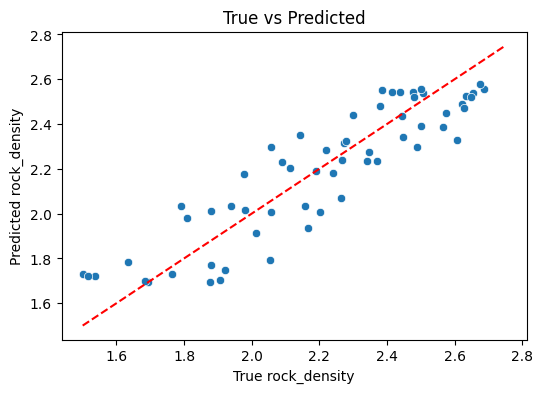

In [ ]:
# Cell 9: Evaluate on test set
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R2: {r2:.4f}")

# Plot predictions vs true
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
plt.xlabel("True rock_density")
plt.ylabel("Predicted rock_density")
plt.title("True vs Predicted")
plt.show()

In [ ]:
# Cell 11: Save model and metadata
model_path = os.path.join(MODEL_DIR, "rf_rebound_density.joblib")
joblib.dump(best_model, model_path)

meta = {
    "model_file": model_path,
    "features": X.columns.tolist(),
    "target": "rock_density",
    "random_state": RANDOM_STATE,
    "cv_best_score_rmse": -gs.best_score_
}
with open(os.path.join(MODEL_DIR, "model_metadata.json"), "w") as f:
    json.dump(meta, f, indent=2)

print("Saved model to", model_path)

Saved model to models/rf_rebound_density.joblib


In [ ]:
# Cell 12: Quick local prediction
sample = pd.DataFrame({"rebound_signal": [50.0, 10.0, 90.0]})
preds = best_model.predict(sample)
print("Samples:\n", sample)
print("Predictions:\n", preds)

Samples:
    rebound_signal
0            50.0
1            10.0
2            90.0
Predictions:
 [1.70317104 2.55209371 2.29654645]
